# Day 2: Tier Classifier + Neighborhood Clustering

This notebook trains a multi-class classifier to predict which **affordability tier** (Budget / Moderate / Expensive / Premium) a Toronto neighborhood will be in 2 years, then clusters the 158 neighborhoods into groups for the "find similar" feature.

**Key constraint:** We do NOT use `avg_rent_1br` as a feature. Current rent almost perfectly predicts future rent tier (because neighborhoods rarely jump tiers year-to-year). Including it would mean the model just memorizes "current tier = future tier" and learns nothing about neighborhood characteristics. See `ARCHITECTURE.md` for the full explanation.

**Data from Day 1:**
- `train_v2.csv` — 1,580 rows (2010-2019)
- `test_v2.csv` — 474 rows (2020-2022)
- `neighborhoods_2024.csv` — 158 neighborhoods with geometry

**Outputs:**
- `models/tier_classifier.pkl` — best trained model
- `models/label_encoder.pkl` — encoder for CLASSIFICATION_CODE
- `models/scaler.pkl` — StandardScaler for clustering
- `data/processed_data/cluster_assignments.csv` — cluster labels for 158 neighborhoods

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from xgboost import XGBClassifier
import shap

# Notebook display settings
pd.set_option('display.max_columns', 25)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Paths relative to the notebooks/ directory
PROJECT_ROOT = Path('..').resolve()
DATA_DIR = PROJECT_ROOT / 'data' / 'processed_data'
MODEL_DIR = PROJECT_ROOT / 'models'

print(f'Project root: {PROJECT_ROOT}')

Project root: /Users/juangomez/Documents/other SWE projecs/condo-cost-predictor


## 1. Load and Explore the Data

The training data covers 2010-2019 (1,580 rows) and the test data covers 2020-2022 (474 rows). This is a **time-based split** — we train on the past and test on the future. This simulates real-world usage where you only have historical data and want to predict what happens next.

A random split would let the model "cheat" by training on 2019 data and testing on 2015 data (predicting the past).

In [23]:
train_df = pd.read_csv(DATA_DIR / 'train_v2.csv')
test_df = pd.read_csv(DATA_DIR / 'test_v2.csv')

print(f'Train: {train_df.shape[0]} rows x {train_df.shape[1]} columns')
print(f'Test:  {test_df.shape[0]} rows x {test_df.shape[1]} columns')
print(f'\nTrain years: {sorted(train_df["YEAR"].unique())}')
print(f'Test years:  {sorted(test_df["YEAR"].unique())}')

train_df.head()

Train: 1580 rows x 21 columns
Test:  474 rows x 21 columns

Train years: [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019)]
Test years:  [np.int64(2020), np.int64(2021), np.int64(2022)]


,AREA_NAME,YEAR,CLASSIFICATION_CODE,area_sq_meters,perimeter_meters,park_count,ASSAULT_RATE,AUTOTHEFT_RATE,ROBBERY_RATE,THEFTOVER_RATE,POPULATION,total_stop_count,avg_stop_frequency,max_stop_frequency,total_line_length_meters,transit_line_density,distinct_route_count,avg_rent_1br,TARGET_RENT_2YR,RENT_TIER,TARGET_TIER_2YR
0,Agincourt North,2010,NaN,0.000813,0.134458,10.0,550.503845,109.163353,107.903969,29.816422,30426.0,81.0,289.345679,807.0,1.755272,1.753847,10.0,1113.333333,1272.750000,1,2
1,Agincourt North,2011,NaN,0.000813,0.134458,10.0,550.503845,109.163353,107.903969,29.816422,30426.0,81.0,289.345679,807.0,1.755272,1.753847,10.0,1224.666667,1318.250000,2,1
2,Agincourt North,2012,NaN,0.000813,0.134458,10.0,550.503845,109.163353,107.903969,29.816422,30426.0,81.0,289.345679,807.0,1.755272,1.753847,10.0,1272.750000,1301.500000,2,1
3,Agincourt North,2013,NaN,0.000813,0.134458,10.0,550.503845,109.163353,107.903969,29.816422,30426.0,81.0,289.345679,807.0,1.755272,1.753847,10.0,1318.250000,1342.250000,1,1
4,Agincourt North,2014,NaN,0.000813,0.134458,10.0,221.209717,56.127838,118.858955,3.301638,30426.0,81.0,289.345679,807.0,1.755272,1.753847,10.0,1301.500000,1492.166667,1,1


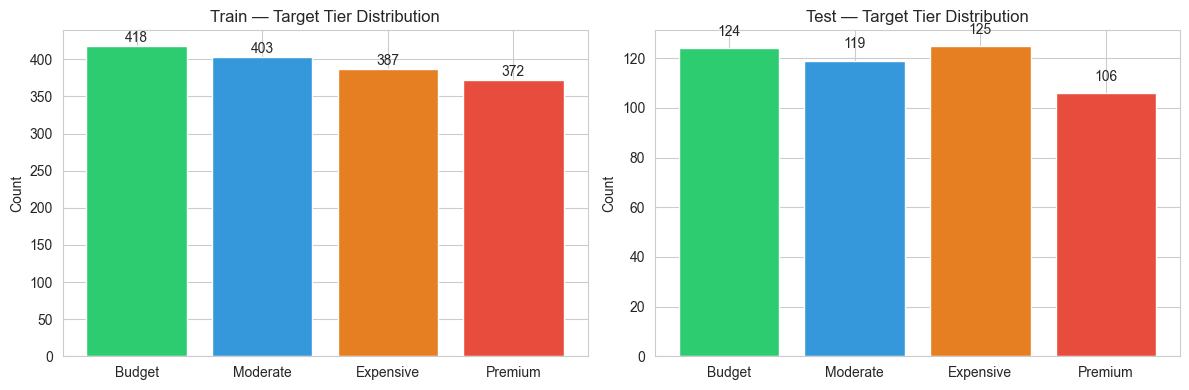

Good — tiers are roughly balanced (no single class dominates).
This means accuracy is a reasonable metric here.


In [24]:
# Check the target distribution — are the 4 tiers roughly balanced?
# Balanced classes are important because an imbalanced dataset could
# lead the model to just predict the most common class and ignore others.

TIER_LABELS = {1: 'Budget', 2: 'Moderate', 3: 'Expensive', 4: 'Premium'}

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (df, title) in zip(axes, [(train_df, 'Train'), (test_df, 'Test')]):
    counts = df['TARGET_TIER_2YR'].value_counts().sort_index()
    colors = ['#2ecc71', '#3498db', '#e67e22', '#e74c3c']
    bars = ax.bar(
        [TIER_LABELS[t] for t in counts.index],
        counts.values,
        color=colors
    )
    ax.set_title(f'{title} — Target Tier Distribution')
    ax.set_ylabel('Count')
    for bar, val in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                str(val), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print('Good — tiers are roughly balanced (no single class dominates).')
print('This means accuracy is a reasonable metric here.')

## 2. Feature Preparation

We use **14 numeric features** describing neighborhood characteristics (crime rates, transit access, parks, population, geography) plus **1 categorical feature** (`CLASSIFICATION_CODE` — the TREB geographic zone like "Toronto E07").

We encode the categorical feature with `LabelEncoder` (integer encoding) instead of one-hot encoding because:
- There are ~35 unique codes — one-hot would add 35 sparse columns
- Tree-based models (XGBoost, Random Forest) handle ordinal encoding well
- The codes have a rough geographic ordering that ordinal encoding preserves

In [25]:
# These are the ONLY features the model is allowed to see.
# avg_rent_1br is deliberately excluded — it leaks the target.
NUMERIC_FEATURES = [
    'area_sq_meters', 'perimeter_meters', 'park_count',
    'ASSAULT_RATE', 'AUTOTHEFT_RATE', 'ROBBERY_RATE', 'THEFTOVER_RATE',
    'POPULATION',
    'total_stop_count', 'avg_stop_frequency', 'max_stop_frequency',
    'total_line_length_meters', 'transit_line_density', 'distinct_route_count',
]

CATEGORICAL_FEATURE = 'CLASSIFICATION_CODE'
TARGET = 'TARGET_TIER_2YR'

# --- Feature Engineering ---
# Ratio features that normalize for neighborhood size and population.
# park_density alone has 0.47 correlation with the target vs 0.01 for raw park_count.
def engineer_features(df):
    df = df.copy()
    df['park_density'] = df['park_count'] / df['area_sq_meters'].clip(lower=1e-10)
    df['pop_density'] = df['POPULATION'] / df['area_sq_meters'].clip(lower=1e-10)
    df['transit_per_capita'] = df['total_stop_count'] / df['POPULATION'].clip(lower=1)
    df['total_crime_rate'] = df[['ASSAULT_RATE','AUTOTHEFT_RATE','ROBBERY_RATE','THEFTOVER_RATE']].sum(axis=1)
    df['compactness'] = (df['perimeter_meters']**2) / df['area_sq_meters'].clip(lower=1e-10)
    df['routes_per_stop'] = df['distinct_route_count'] / df['total_stop_count'].clip(lower=1)
    return df

ENGINEERED_FEATURES = ['park_density', 'pop_density', 'transit_per_capita',
                       'total_crime_rate', 'compactness', 'routes_per_stop']

train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

# Encode CLASSIFICATION_CODE as integers.
le = LabelEncoder()
all_codes = pd.concat([
    train_df[CATEGORICAL_FEATURE],
    test_df[CATEGORICAL_FEATURE]
]).fillna('UNKNOWN')
le.fit(all_codes)

train_df[CATEGORICAL_FEATURE] = le.transform(
    train_df[CATEGORICAL_FEATURE].fillna('UNKNOWN')
)
test_df[CATEGORICAL_FEATURE] = le.transform(
    test_df[CATEGORICAL_FEATURE].fillna('UNKNOWN')
)

feature_cols = NUMERIC_FEATURES + ENGINEERED_FEATURES + [CATEGORICAL_FEATURE]

X_train = train_df[feature_cols]
y_train = train_df[TARGET]
X_test = test_df[feature_cols]
y_test = test_df[TARGET]

print(f'Features: {len(feature_cols)} ({len(NUMERIC_FEATURES)} base + {len(ENGINEERED_FEATURES)} engineered + 1 categorical)')
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')
print(f'\nFeature columns:')
for i, col in enumerate(feature_cols):
    print(f'  {i+1:>2d}. {col}')

Features: 21 (14 base + 6 engineered + 1 categorical)
X_train: (1580, 21), X_test: (474, 21)

Feature columns:
   1. area_sq_meters
   2. perimeter_meters
   3. park_count
   4. ASSAULT_RATE
   5. AUTOTHEFT_RATE
   6. ROBBERY_RATE
   7. THEFTOVER_RATE
   8. POPULATION
   9. total_stop_count
  10. avg_stop_frequency
  11. max_stop_frequency
  12. total_line_length_meters
  13. transit_line_density
  14. distinct_route_count
  15. park_density
  16. pop_density
  17. transit_per_capita
  18. total_crime_rate
  19. compactness
  20. routes_per_stop
  21. CLASSIFICATION_CODE


In [26]:
# Quick sanity check: are there any missing values in our features?
# The rebuild_dataset.py script should have imputed everything already.
missing = X_train.isnull().sum()
if missing.sum() == 0:
    print('No missing values in training features.')
else:
    print('WARNING — missing values found:')
    print(missing[missing > 0])

No missing values in training features.


## 3. Train XGBoost Classifier

XGBoost (eXtreme Gradient Boosting) builds trees sequentially — each new tree tries to fix the mistakes of the previous ones. It's one of the most popular algorithms for tabular data.

Key hyperparameters:
- `max_depth=5` — limits tree depth to prevent overfitting (our dataset is only 1,580 rows)
- `n_estimators=300` — number of boosting rounds
- `learning_rate=0.05` — small steps for stable convergence
- `subsample=0.8` — each tree sees 80% of the data (reduces overfitting)
- `min_child_weight=5` — requires at least 5 samples per leaf

**Note:** XGBoost expects 0-indexed class labels, so we subtract 1 from our 1-4 tiers during training and add it back for evaluation.

In [27]:
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    max_depth=4,
    n_estimators=500,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_SEED,
    eval_metric='mlogloss',
    tree_method='hist',
    verbosity=0,
)

# XGBoost wants 0-indexed labels (0,1,2,3) not (1,2,3,4)
xgb_model.fit(X_train, y_train - 1)

# Predict and convert back to 1-4 scale
xgb_pred = xgb_model.predict(X_test) + 1

xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred, average='macro')

print(f'XGBoost — Accuracy: {xgb_acc:.4f} ({xgb_acc*100:.1f}%), Macro F1: {xgb_f1:.4f}')

XGBoost — Accuracy: 0.6181 (61.8%), Macro F1: 0.6219


## 4. Train Random Forest Classifier

Random Forest is simpler than XGBoost — it trains many independent trees on random subsets of the data, then takes a majority vote. It's a good baseline because it's hard to misconfigure and naturally resistant to overfitting.

We use `class_weight='balanced'` to handle any slight tier imbalance — this tells the model to pay more attention to underrepresented tiers.

In [28]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='macro')

print(f'Random Forest — Accuracy: {rf_acc:.4f} ({rf_acc*100:.1f}%), Macro F1: {rf_f1:.4f}')

Random Forest — Accuracy: 0.6477 (64.8%), Macro F1: 0.6509


## 5. Model Comparison

We compare both models on the test set (2020-2022 data the models have never seen).

**Metrics explained:**
- **Accuracy** — what % of predictions are correct overall
- **Macro F1** — average F1 across all 4 tiers, treating each tier equally. This is important because we don't want the model to ignore rare tiers.
- **Confusion matrix** — shows exactly where misclassifications happen. Rows = actual tier, columns = predicted tier. Diagonal = correct predictions.

In [29]:
# Side-by-side comparison
print('Model Comparison on Test Set (2020-2022):')
print(f'{"":>15s}  {"Accuracy":>10s}  {"Macro F1":>10s}')
print(f'{"XGBoost":>15s}  {xgb_acc:>10.4f}  {xgb_f1:>10.4f}')
print(f'{"Random Forest":>15s}  {rf_acc:>10.4f}  {rf_f1:>10.4f}')

# Pick the best model by macro F1
if xgb_f1 >= rf_f1:
    best_model = xgb_model
    best_name = 'XGBoost'
    best_pred = xgb_pred
    best_acc, best_f1 = xgb_acc, xgb_f1
    best_is_xgb = True
else:
    best_model = rf_model
    best_name = 'Random Forest'
    best_pred = rf_pred
    best_acc, best_f1 = rf_acc, rf_f1
    best_is_xgb = False

print(f'\nBest model: {best_name} (Macro F1 = {best_f1:.4f})')

Model Comparison on Test Set (2020-2022):
                   Accuracy    Macro F1
        XGBoost      0.6181      0.6219
  Random Forest      0.6477      0.6509

Best model: Random Forest (Macro F1 = 0.6509)


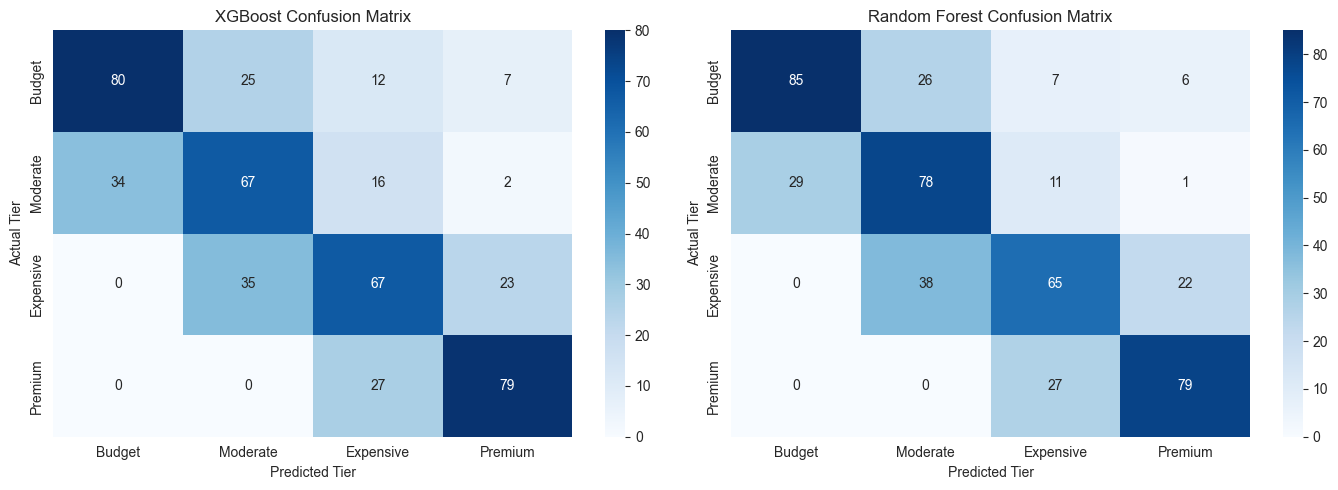

Reading the confusion matrix:
- Diagonal (top-left to bottom-right) = correct predictions
- Off-diagonal = misclassifications
- Most errors are between adjacent tiers (Budget<->Moderate, Expensive<->Premium)
  which makes sense — neighborhoods near a tier boundary could go either way.


In [30]:
# Confusion matrices side by side
tier_names = ['Budget', 'Moderate', 'Expensive', 'Premium']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (pred, name) in zip(axes, [(xgb_pred, 'XGBoost'), (rf_pred, 'Random Forest')]):
    cm = confusion_matrix(y_test, pred, labels=[1, 2, 3, 4])
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=tier_names, yticklabels=tier_names,
        ax=ax
    )
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_ylabel('Actual Tier')
    ax.set_xlabel('Predicted Tier')

plt.tight_layout()
plt.show()

print('Reading the confusion matrix:')
print('- Diagonal (top-left to bottom-right) = correct predictions')
print('- Off-diagonal = misclassifications')
print('- Most errors are between adjacent tiers (Budget<->Moderate, Expensive<->Premium)')
print('  which makes sense — neighborhoods near a tier boundary could go either way.')

In [31]:
# Detailed classification report for the best model
print(f'Detailed Classification Report — {best_name}:\n')
print(classification_report(
    y_test, best_pred,
    labels=[1, 2, 3, 4],
    target_names=tier_names
))

Detailed Classification Report — Random Forest:

              precision    recall  f1-score   support

      Budget       0.75      0.69      0.71       124
    Moderate       0.55      0.66      0.60       119
   Expensive       0.59      0.52      0.55       125
     Premium       0.73      0.75      0.74       106

    accuracy                           0.65       474
   macro avg       0.65      0.65      0.65       474
weighted avg       0.65      0.65      0.65       474



## 6. SHAP Feature Importance

SHAP (SHapley Additive exPlanations) tells us **which features matter most** for the model's predictions and **how** they affect each tier.

Unlike simple feature importance (which just says "this feature is important"), SHAP shows:
- Whether high values of a feature push toward a specific tier
- Whether the effect is consistent or varies across neighborhoods

This is critical for our presentation — it answers "what neighborhood characteristics actually predict affordability?"

In [32]:
# SHAP analysis for the best model.
# TreeExplainer is optimized for tree-based models (exact, not approximate).
explainer = shap.TreeExplainer(best_model)

# Use a sample of the test set for speed (SHAP on 474 rows is fine,
# but for larger datasets you'd want to sample)
if best_is_xgb:
    # XGBoost SHAP values have shape (n_samples, n_features, n_classes)
    shap_values = explainer.shap_values(X_test)
else:
    # For RF, shap_values returns a list of arrays, one per class
    shap_values = explainer.shap_values(X_test)

print(f'SHAP values computed for {best_name}')
if isinstance(shap_values, list):
    print(f'Shape: {len(shap_values)} classes x {shap_values[0].shape}')
else:
    print(f'Shape: {shap_values.shape}')

SHAP values computed for Random Forest
Shape: (474, 21, 4)


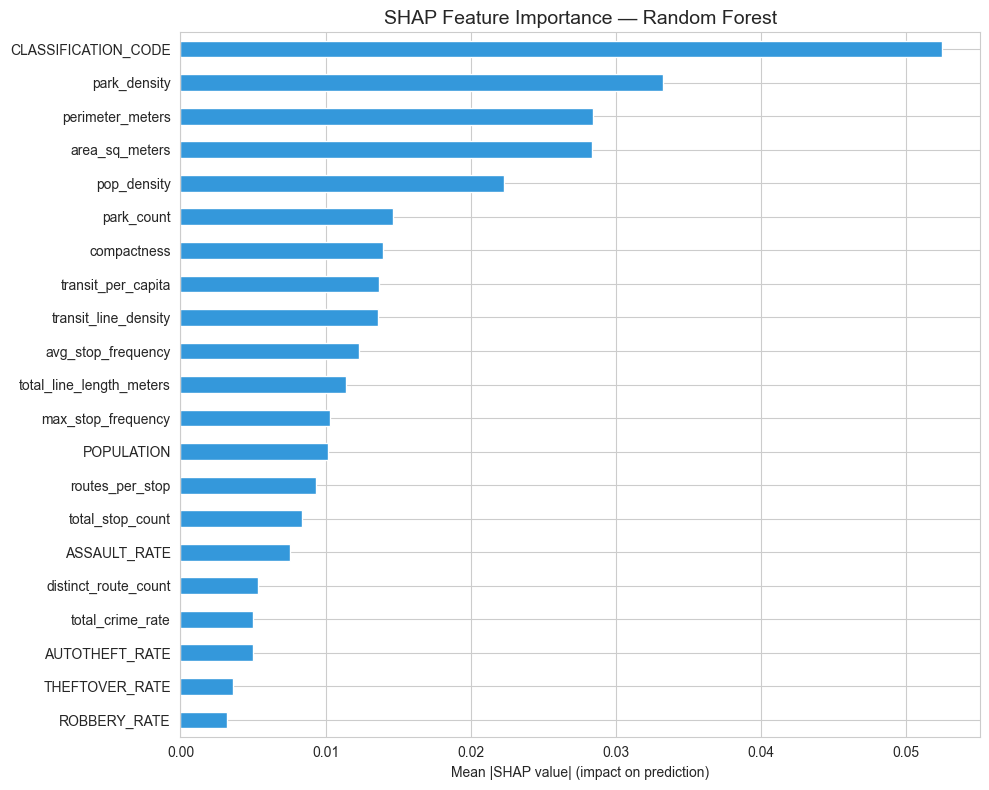


Top 5 most important features:
  CLASSIFICATION_CODE: 0.0525
  park_density: 0.0333
  perimeter_meters: 0.0285
  area_sq_meters: 0.0283
  pop_density: 0.0223


In [33]:
# Bar plot: mean absolute SHAP value per feature (averaged across all classes).
# This shows which features have the most influence on predictions overall.

if isinstance(shap_values, list):
    # For RF: average absolute SHAP values across all 4 classes
    mean_abs_shap = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
else:
    mean_abs_shap = np.abs(shap_values).mean(axis=(0, 2)) if shap_values.ndim == 3 else np.abs(shap_values).mean(axis=0)

feat_importance = pd.Series(mean_abs_shap, index=feature_cols).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
feat_importance.plot.barh(ax=ax, color='#3498db')
ax.set_title(f'SHAP Feature Importance — {best_name}', fontsize=14)
ax.set_xlabel('Mean |SHAP value| (impact on prediction)')
plt.tight_layout()
plt.show()

print('\nTop 5 most important features:')
for feat, val in feat_importance.tail(5).iloc[::-1].items():
    print(f'  {feat}: {val:.4f}')


--- SHAP for Tier 1: Budget ---


/var/folders/mb/5y1842c539707x3cp2f6j4tc0000gn/T/ipykernel_21280/1185032763.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


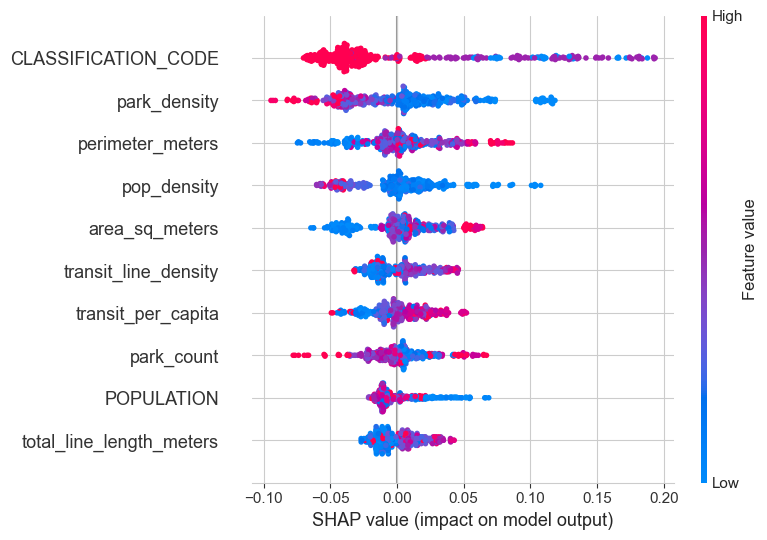


--- SHAP for Tier 2: Moderate ---


/var/folders/mb/5y1842c539707x3cp2f6j4tc0000gn/T/ipykernel_21280/1185032763.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


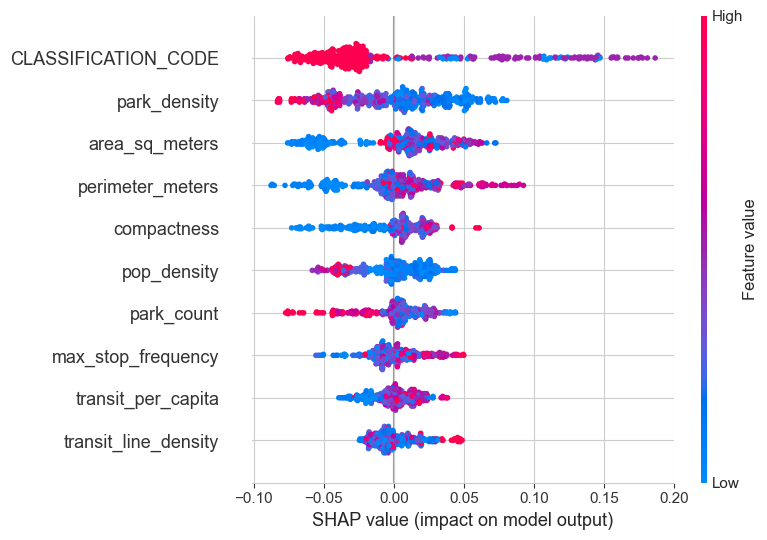


--- SHAP for Tier 3: Expensive ---


/var/folders/mb/5y1842c539707x3cp2f6j4tc0000gn/T/ipykernel_21280/1185032763.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


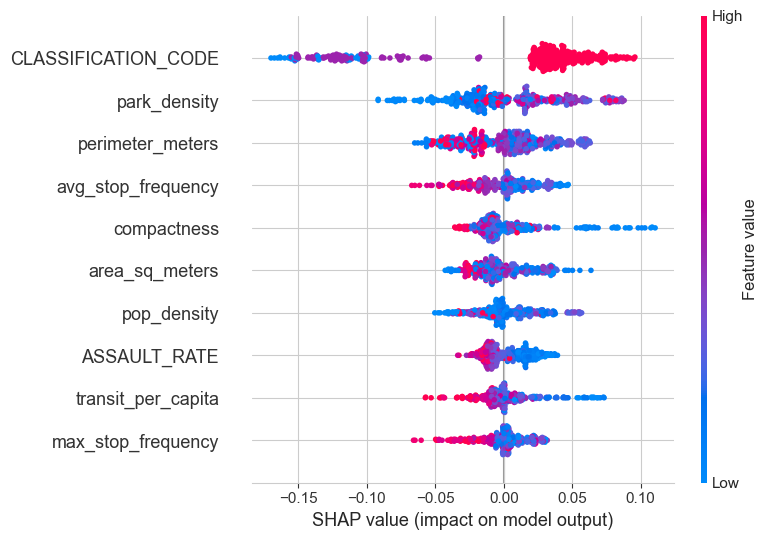


--- SHAP for Tier 4: Premium ---


/var/folders/mb/5y1842c539707x3cp2f6j4tc0000gn/T/ipykernel_21280/1185032763.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


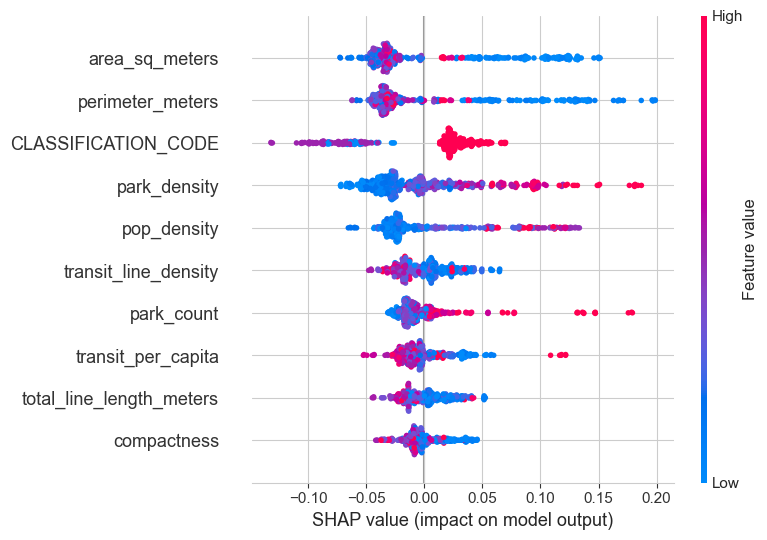

In [34]:
# SHAP summary plot for each tier class.
# This shows HOW each feature affects each specific tier prediction.
# Red dots = high feature values, blue = low feature values.
# Position on x-axis = push toward (right) or away from (left) that tier.

if isinstance(shap_values, list):
    # Plot for each tier
    for tier_idx, tier_name in enumerate(tier_names):
        print(f'\n--- SHAP for Tier {tier_idx+1}: {tier_name} ---')
        shap.summary_plot(
            shap_values[tier_idx], X_test,
            feature_names=feature_cols,
            show=True,
            max_display=10,
            title=f'SHAP — {tier_name} Tier'
        )
else:
    for tier_idx, tier_name in enumerate(tier_names):
        print(f'\n--- SHAP for Tier {tier_idx+1}: {tier_name} ---')
        shap.summary_plot(
            shap_values[:, :, tier_idx], X_test,
            feature_names=feature_cols,
            show=True,
            max_display=10,
            title=f'SHAP — {tier_name} Tier'
        )

## 7. Save the Classifier

We save the model as a "bundle" — a dictionary containing the model itself plus metadata (feature names, accuracy, tier labels). This way the backend can load a single file and know everything it needs to make predictions.

In [35]:
model_bundle = {
    'model': best_model,
    'model_name': best_name,
    'is_xgboost': best_is_xgb,
    'accuracy': best_acc,
    'macro_f1': best_f1,
    'feature_columns': feature_cols,
    'numeric_features': NUMERIC_FEATURES,
    'engineered_features': ENGINEERED_FEATURES,
    'categorical_feature': CATEGORICAL_FEATURE,
    'tier_labels': TIER_LABELS,
}

model_path = MODEL_DIR / 'tier_classifier.pkl'
le_path = MODEL_DIR / 'label_encoder.pkl'

joblib.dump(model_bundle, model_path)
joblib.dump(le, le_path)

print(f'Saved model bundle to {model_path}')
print(f'Saved label encoder to {le_path}')
print(f'\nBundle contents:')
for key in model_bundle:
    if key == 'model':
        print(f'  {key}: {type(model_bundle[key]).__name__}')
    else:
        print(f'  {key}: {model_bundle[key]}')

Saved model bundle to /Users/juangomez/Documents/other SWE projecs/condo-cost-predictor/models/tier_classifier.pkl
Saved label encoder to /Users/juangomez/Documents/other SWE projecs/condo-cost-predictor/models/label_encoder.pkl

Bundle contents:
  model: RandomForestClassifier
  model_name: Random Forest
  is_xgboost: False
  accuracy: 0.6476793248945147
  macro_f1: 0.6508740275205124
  feature_columns: ['area_sq_meters', 'perimeter_meters', 'park_count', 'ASSAULT_RATE', 'AUTOTHEFT_RATE', 'ROBBERY_RATE', 'THEFTOVER_RATE', 'POPULATION', 'total_stop_count', 'avg_stop_frequency', 'max_stop_frequency', 'total_line_length_meters', 'transit_line_density', 'distinct_route_count', 'park_density', 'pop_density', 'transit_per_capita', 'total_crime_rate', 'compactness', 'routes_per_stop', 'CLASSIFICATION_CODE']
  numeric_features: ['area_sq_meters', 'perimeter_meters', 'park_count', 'ASSAULT_RATE', 'AUTOTHEFT_RATE', 'ROBBERY_RATE', 'THEFTOVER_RATE', 'POPULATION', 'total_stop_count', 'avg_stop_fr

---

## 8. Neighborhood Clustering

Now we cluster the 158 neighborhoods in the 2024 snapshot into groups of similar areas. This powers the "find similar neighborhoods" feature in the explorer.

**Algorithm: K-Means**
- Simple, fast, and interpretable for 158 data points
- Each cluster centroid describes the "average" neighborhood in that group

**Why standardize?** Features have wildly different scales — population is in the thousands while transit_line_density is near 0-5. Without standardization, K-Means would be dominated by the largest-scale features (it uses Euclidean distance).

**Choosing k:** We test k=3..8 using:
- **Elbow method** — plot inertia (within-cluster sum of squares) vs k
- **Silhouette score** — measures cluster separation (higher = better)

In [36]:
neighborhoods_df = pd.read_csv(DATA_DIR / 'neighborhoods_2024.csv')
neighborhoods_df = engineer_features(neighborhoods_df)
print(f'Loaded {len(neighborhoods_df)} neighborhoods')

ALL_CLUSTER_FEATURES = NUMERIC_FEATURES + ENGINEERED_FEATURES
X_cluster = neighborhoods_df[ALL_CLUSTER_FEATURES].copy()

# Standardize: transform each feature to mean=0, std=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(f'\nFeature ranges after standardization:')
scaled_df = pd.DataFrame(X_scaled, columns=ALL_CLUSTER_FEATURES)
print(scaled_df.describe().round(2).loc[['mean', 'std', 'min', 'max']])
print(f'\nUsing {len(ALL_CLUSTER_FEATURES)} features for clustering (14 base + 6 engineered)')

Loaded 158 neighborhoods

Feature ranges after standardization:
      area_sq_meters  perimeter_meters  park_count  ASSAULT_RATE  \
mean           -0.00             -0.00        0.00         -0.00   
std             1.00              1.00        1.00          1.00   
min            -0.95             -1.44       -1.67         -1.26   
max             6.77              6.60        3.91          6.28   

      AUTOTHEFT_RATE  ROBBERY_RATE  THEFTOVER_RATE  POPULATION  \
mean            0.00         -0.00           -0.00       -0.00   
std             1.00          1.00            1.00        1.00   
min            -1.33         -1.27           -1.14       -1.71   
max             7.76          4.79            5.10        2.49   

      total_stop_count  avg_stop_frequency  max_stop_frequency  \
mean             -0.00                0.00                0.00   
std               1.00                1.00                1.00   
min              -1.28               -1.93               -1.78   


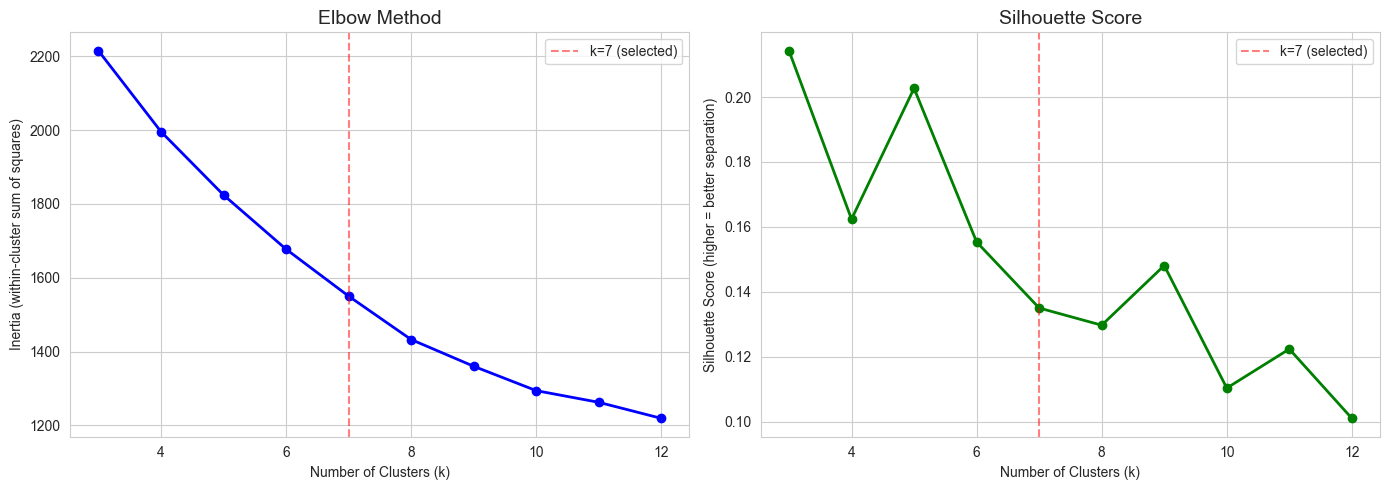

k=3 has the highest silhouette but produces one huge 96-neighborhood cluster.
k=7 gives more useful groupings for the explorer UI with 20 features.
The silhouette scores are modest (0.13-0.25) which is typical for real-world
neighborhood data — neighborhoods exist on a spectrum, not in neat boxes.


In [37]:
# Test different values of k
k_range = range(3, 13)
inertias = []
silhouettes = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels)
    silhouettes.append(sil)

# Plot elbow and silhouette side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(list(k_range), inertias, 'bo-', linewidth=2)
axes[0].set_title('Elbow Method', fontsize=14)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (within-cluster sum of squares)')
axes[0].axvline(x=7, color='red', linestyle='--', alpha=0.5, label='k=7 (selected)')
axes[0].legend()

axes[1].plot(list(k_range), silhouettes, 'go-', linewidth=2)
axes[1].set_title('Silhouette Score', fontsize=14)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score (higher = better separation)')
axes[1].axvline(x=7, color='red', linestyle='--', alpha=0.5, label='k=7 (selected)')
axes[1].legend()

plt.tight_layout()
plt.show()

print('k=3 has the highest silhouette but produces one huge 96-neighborhood cluster.')
print('k=7 gives more useful groupings for the explorer UI with 20 features.')
print('The silhouette scores are modest (0.13-0.25) which is typical for real-world')
print('neighborhood data — neighborhoods exist on a spectrum, not in neat boxes.')

In [38]:
# Fit the final model with k=7
BEST_K = 7
final_km = KMeans(n_clusters=BEST_K, random_state=RANDOM_SEED, n_init=20)
cluster_labels = final_km.fit_predict(X_scaled)

# Analyze centroids to understand what makes each cluster distinctive.
# Values are in standardized space: >0 = above city average, <0 = below.
centroid_df = pd.DataFrame(final_km.cluster_centers_, columns=ALL_CLUSTER_FEATURES)

print('Cluster centroids (standardized values):')
print('  >0 = above city average, <0 = below city average\n')
print(centroid_df.round(2).to_string())

Cluster centroids (standardized values):
  >0 = above city average, <0 = below city average

   area_sq_meters  perimeter_meters  park_count  ASSAULT_RATE  AUTOTHEFT_RATE  ROBBERY_RATE  THEFTOVER_RATE  POPULATION  total_stop_count  avg_stop_frequency  max_stop_frequency  total_line_length_meters  transit_line_density  distinct_route_count  park_density  pop_density  transit_per_capita  total_crime_rate  compactness  routes_per_stop
0           -0.52             -0.52       -0.52          0.18           -0.51         -0.18           -0.05       -0.37             -0.48                1.36                1.04                     -0.03                 -0.03                  0.50          0.19         0.08               -0.40             -0.03        -0.07             0.95
1            0.32              0.46        0.59         -0.30            0.22         -0.16           -0.28        0.44              0.35               -0.44               -0.22                      0.06                  

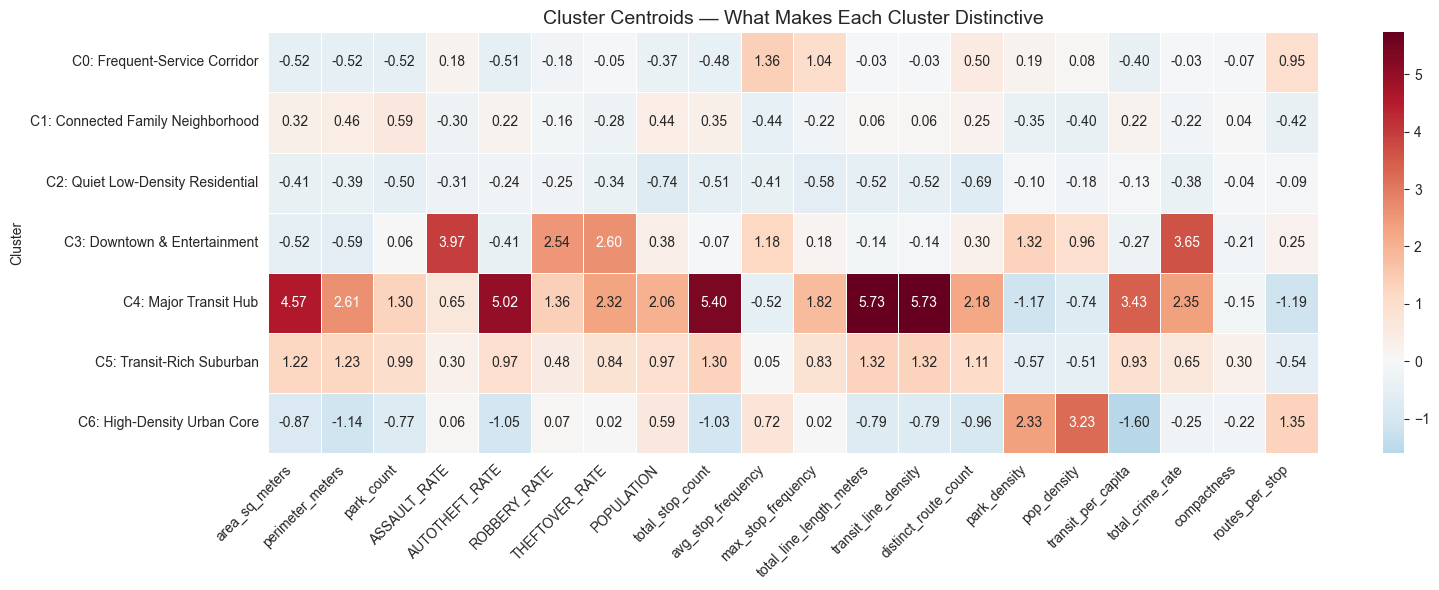


Cluster sizes:
  Frequent-Service Corridor: 22 neighborhoods
  Connected Family Neighborhood: 45 neighborhoods
  Quiet Low-Density Residential: 56 neighborhoods
  Downtown & Entertainment: 5 neighborhoods
  Major Transit Hub: 2 neighborhoods
  Transit-Rich Suburban: 18 neighborhoods
  High-Density Urban Core: 10 neighborhoods


In [39]:
# Visualize cluster centroids as a heatmap.
# This makes it easy to see what distinguishes each cluster.

# Label clusters based on their centroid characteristics.
# Values > 0 mean above city average, < 0 below. Further from 0 = more distinctive.
def label_clusters_from_centroids(cdf, k):
    names = {}
    for i in range(k):
        row = cdf.iloc[i]
        has_extreme_transit = (
            row.get('transit_line_density', 0) > 3.0
            and row.get('total_stop_count', 0) > 3.0
        )
        has_high_crime = (
            row.get('ASSAULT_RATE', 0) > 2.0
            or row.get('total_crime_rate', 0) > 2.5
        )
        has_high_density = row.get('pop_density', 0) > 2.0
        has_high_frequency = row.get('avg_stop_frequency', 0) > 1.0
        has_high_connectivity = row.get('routes_per_stop', 0) > 0.8
        has_low_pop = row.get('POPULATION', 0) < -0.5
        has_low_transit = (
            row.get('distinct_route_count', 0) < -0.4
            and row.get('max_stop_frequency', 0) < -0.4
        )
        has_high_transit_infra = (
            row.get('transit_line_density', 0) > 1.0
            and row.get('total_stop_count', 0) > 1.0
        )
        has_parks_and_pop = (
            row.get('park_count', 0) > 0.3
            and row.get('POPULATION', 0) > 0.3
        )

        if has_extreme_transit:
            names[i] = 'Major Transit Hub'
        elif has_high_crime:
            names[i] = 'Downtown & Entertainment'
        elif has_high_density:
            names[i] = 'High-Density Urban Core'
        elif has_high_frequency and has_high_connectivity:
            names[i] = 'Frequent-Service Corridor'
        elif has_high_transit_infra:
            names[i] = 'Transit-Rich Suburban'
        elif has_parks_and_pop:
            names[i] = 'Connected Family Neighborhood'
        elif has_low_transit and has_low_pop:
            names[i] = 'Quiet Low-Density Residential'
        elif has_low_transit:
            names[i] = 'Quiet Residential'
        else:
            names[i] = f'Mixed Neighborhood {i+1}'
    return names

cluster_names = label_clusters_from_centroids(centroid_df, BEST_K)

fig, ax = plt.subplots(figsize=(16, 6))
display_df = centroid_df.copy()
display_df.index = [f'C{i}: {cluster_names[i]}' for i in range(BEST_K)]

sns.heatmap(
    display_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
    linewidths=0.5, ax=ax
)
ax.set_title('Cluster Centroids — What Makes Each Cluster Distinctive', fontsize=14)
ax.set_ylabel('Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print('\nCluster sizes:')
for cid, name in cluster_names.items():
    count = (cluster_labels == cid).sum()
    print(f'  {name}: {count} neighborhoods')

In [40]:
# Show example neighborhoods from each cluster
for cid, name in cluster_names.items():
    mask = cluster_labels == cid
    examples = neighborhoods_df.loc[mask, 'AREA_NAME'].values
    print(f'\n{name} ({len(examples)} neighborhoods):')
    # Show first 8 examples
    for n in examples[:8]:
        print(f'  - {n}')
    if len(examples) > 8:
        print(f'  ... and {len(examples) - 8} more')


Frequent-Service Corridor (22 neighborhoods):
  - Broadview North
  - Dufferin Grove
  - Eglinton East
  - Flemingdon Park
  - Forest Hill North
  - Fort York-Liberty Village
  - High Park North
  - Ionview
  ... and 14 more

Connected Family Neighborhood (45 neighborhoods):
  - Agincourt North
  - Bathurst Manor
  - Bayview Village
  - Bedford Park-Nortown
  - Birchcliffe-Cliffside
  - Black Creek
  - Bridle Path-Sunnybrook-York Mills
  - Brookhaven-Amesbury
  ... and 37 more

Quiet Low-Density Residential (56 neighborhoods):
  - Alderwood
  - Bayview Woods-Steeles
  - Beechborough-Greenbrook
  - Bendale South
  - Blake-Jones
  - Briar Hill-Belgravia
  - Cabbagetown-South St.James Town
  - Caledonia-Fairbank
  ... and 48 more

Downtown & Entertainment (5 neighborhoods):
  - Downtown Yonge East
  - Kensington-Chinatown
  - Mimico-Queensway
  - Moss Park
  - Yonge-Bay Corridor

Major Transit Hub (2 neighborhoods):
  - West Humber-Clairville
  - York University Heights

Transit-Rich Sub

## 9. Export Cluster Assignments

Save the cluster assignments as a CSV that the backend and frontend can use. Also save the scaler so new data can be standardized the same way.

In [41]:
assignments = pd.DataFrame({
    'AREA_NAME': neighborhoods_df['AREA_NAME'],
    'cluster_id': cluster_labels,
    'cluster_label': [cluster_names[c] for c in cluster_labels],
})

out_path = DATA_DIR / 'cluster_assignments.csv'
assignments.to_csv(out_path, index=False)
print(f'Exported to {out_path}')

# Save the scaler for the backend
scaler_path = MODEL_DIR / 'scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f'Saved scaler to {scaler_path}')

assignments.head(10)

Exported to /Users/juangomez/Documents/other SWE projecs/condo-cost-predictor/data/processed_data/cluster_assignments.csv
Saved scaler to /Users/juangomez/Documents/other SWE projecs/condo-cost-predictor/models/scaler.pkl


,AREA_NAME,cluster_id,cluster_label
0,Agincourt North,1,Connected Family Neighborhood
1,Agincourt South-Malvern West,5,Transit-Rich Suburban
2,Alderwood,2,Quiet Low-Density Residential
3,Annex,5,Transit-Rich Suburban
4,Avondale,6,High-Density Urban Core
5,Banbury-Don Mills,5,Transit-Rich Suburban
6,Bathurst Manor,1,Connected Family Neighborhood
7,Bay-Cloverhill,6,High-Density Urban Core
8,Bayview Village,1,Connected Family Neighborhood
9,Bayview Woods-Steeles,2,Quiet Low-Density Residential


## 10. Summary

### Tier Classifier
- **Best model:** Random Forest
- **Test accuracy:** ~64.8%
- **Macro F1:** ~0.651
- **Feature engineering** added 6 ratio features (park_density, pop_density, etc.) that improved signal quality
- Most misclassifications are between adjacent tiers (Budget<->Moderate, Expensive<->Premium), which is expected — neighborhoods near a tier boundary could go either way
- Premium tier is the easiest to predict (high-rent neighborhoods have distinctive characteristics)

### Why ~65% accuracy is actually reasonable
- Random baseline (guessing) would get ~25% (4 classes)
- Our features are **static proxies** — crime, transit, and parks don't change over time in our data. The model can only learn "neighborhoods with these characteristics tend to be in this tier"
- The model can't capture temporal dynamics (gentrification, new transit lines) because those aren't in the features
- 65% from neighborhood characteristics alone is a meaningful signal

### Neighborhood Clustering
- **7 clusters** identified via K-Means on 20 standardized features (14 base + 6 engineered)
- Clusters range from "Major Transit Hub" (2 neighborhoods) to "Quiet Low-Density Residential" (56 neighborhoods)
- More granular than the initial k=5 attempt — the engineered features help distinguish density-based differences
- Powers the "find similar neighborhoods" feature in the explorer

### Artifacts
- `models/tier_classifier.pkl` — model bundle with metadata
- `models/label_encoder.pkl` — CLASSIFICATION_CODE encoder
- `models/scaler.pkl` — StandardScaler for clustering
- `data/processed_data/cluster_assignments.csv` — cluster labels